In [ ]:
!wget https://github.com/pokleung5/NLP-Fake-New-Classifier/raw/master/Fake.csv
!wget https://github.com/pokleung5/NLP-Fake-New-Classifier/raw/master/True.csv


--2020-05-06 10:26:26--  https://github.com/pokleung5/NLP-Fake-New-Classifier/raw/master/Fake.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pokleung5/temp/master/Fake.csv [following]
--2020-05-06 10:26:27--  https://raw.githubusercontent.com/pokleung5/temp/master/Fake.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62789876 (60M) [text/plain]
Saving to: ‘Fake.csv.1’

Fake.csv.1          100%[===================>]  59.88M  75.5MB/s    in 0.8s    

2020-05-06 10:26:28 (75.5 MB/s) - ‘Fake.csv.1’ saved [62789876/62789876]

--2020-05-06 10:26:29--  https://github.com/pokleung5/NLP-Fake-New-Class

In [ ]:
!pip install pyenchant
!pip install contractions
!apt install libenchant-dev

import nltk 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
Suggested packages:
  aspell-doc spellutils wordlist hunspell openoffice.org-hunspell
  | openoffice.org-core libenchant-voikko
The following NEW packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant-dev libenchant1c2a libhunspell-1.6-0
  libtext-iconv-perl
0 upgraded, 11 newly installed, 0 to remove and 29 not upgraded.
Need to get 1,362 kB of archives.
After this operation, 5,602 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libtext-iconv-perl amd64 1.7-5build6 [13.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libaspell15 amd64 0.60.7~20110707-4u

True

In [ ]:
import pandas as pd
import glob
import os
import csv
import re

In [ ]:
ext = '.csv' # should not be changed !!

directory = './'
filenames = ['True', 'Fake']

label_col = '@label'

# %%
 
dataset = {}

for fn in filenames:
    dataset[fn] = pd.read_csv(os.path.join(directory, fn + ext))
    dataset[fn][label_col] = fn

rawdf = pd.concat(dataset.values()).fillna("").reset_index()


In [ ]:
rawdf['@year'] = rawdf['date'].apply(lambda x:
                               re.search('[0-9]{4}', x).group(0)
                               if re.search('[0-9]{4}', x) is not None
                               else "")

rawdf = rawdf[rawdf['@year'] != ""]

rawdf['@month'] = rawdf['date'].apply(lambda x:
                                re.search('^[ ]*[^ ]{3}', x).group(0))

rawdf.drop('date', axis=1, inplace=True)

df = rawdf[rawdf['@year'] != '2015'] # rawdf[rawdf['@year'] != "2015"]

df['@text'] = df['title'] + ' ' + df['text']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [ ]:

import string
import enchant
import contractions

from nltk import pos_tag #, ne_chunk, tree2conlltags

from nltk.corpus import stopwords, wordnet, words
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

import en_core_web_sm
nlp_tag = en_core_web_sm.load()

tag_dict = {"J": wordnet.ADJ,
            "N": wordnet.NOUN,
            "V": wordnet.VERB,
            "R": wordnet.ADV}

lem = WordNetLemmatizer()
d = enchant.Dict("en_US")

wordsList = set(words.words())
stopwords = set(stopwords.words('english'))

def cleanText(s):
    
    s = re.sub(r'[a-z]+://[^\s]+[\s]?', ' _URL ', s)

    s = contractions.fix(s.lower(), slang=False)
    
    for ent in nlp_tag(s).ents:
        wordsList.add('_' + ent.label_)
        s = s.replace(ent.text, ' ' + '_' + ent.label_ + ' ')

    s = re.sub(r'[^_a-zA-Z]', ' ', s)

    tags = pos_tag(word_tokenize(s)) 

    text = ''

    for word, pos in tags:
        if word[0] == '_' or len(word) > 1 and d.check(word):
            tag = tag_dict.get(pos[0], None)
            if tag is not None: 
                text += lem.lemmatize(word, pos=tag) + ' '
            else:
                text += word + ' '

    return text

from tqdm import tqdm
tqdm.pandas()

df['@text'] = df['@text'].progress_apply(cleanText) # .progress_apply(cleanText)

df.to_csv(os.path.join(directory, 'after_preprocessed_.csv'),
                 index=False, quoting=csv.QUOTE_ALL, doublequote=True)

In [ ]:
# run this cell if runtime crashed
import pandas as pd
import glob
import os
import csv
import re
from nltk.corpus import stopwords, wordnet, words
stopwords = set(stopwords.words('english'))

df = pd.read_csv('after_preprocessed_.csv')


In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


cVect = TfidfVectorizer(
                        # min_df=10,
                        max_features=10000,
                        # preprocessor=cleanText,
                        stop_words=stopwords,
                        # vocabulary=wordsList - stopwords,
                        token_pattern='[_a-zA-z]+[-a-zA-z]+[a-zA-z]+', 
                        ngram_range=(1, 1))


In [ ]:
# %% 
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split

seed=5343

train_features, test_features, train_target, test_target = train_test_split(
    df['@text'], df['@label'], test_size=0.3, random_state=seed)


train_features = cVect.fit_transform(train_features)
train_features = pd.DataFrame(train_features.A, columns=cVect.get_feature_names())

test_features = cVect.transform(test_features)
test_features = pd.DataFrame(test_features.A, columns=cVect.get_feature_names())


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def print_report(target, predictions):
    print(classification_report(target, predictions))
    print(confusion_matrix(target, predictions))


In [ ]:
rfc = RandomForestClassifier()
mNB = MultinomialNB()
dtc = DecisionTreeClassifier()

import time 
start = time.time()

print("RandomForestClassifier")
rfc.fit(train_features, train_target)
predict = rfc.predict(test_features)
print_report(test_target, predict)

end = time.time()
print(end - start)

start = time.time()

print("MultinomialNB")
mNB.fit(train_features, train_target)
predict = mNB.predict(test_features)
print_report(test_target, predict)

end = time.time()
print(end - start)

start = time.time()

print("DecisionTreeClassifier")
dtc.fit(train_features, train_target)
predict = dtc.predict(test_features)
print_report(test_target, predict)

end = time.time()
print(end - start)


RandomForestClassifier
              precision    recall  f1-score   support

        Fake       0.98      0.98      0.98      6398
        True       0.98      0.98      0.98      6315

    accuracy                           0.98     12713
   macro avg       0.98      0.98      0.98     12713
weighted avg       0.98      0.98      0.98     12713

[[6245  153]
 [ 138 6177]]
154.55568504333496
MultinomialNB
              precision    recall  f1-score   support

        Fake       0.93      0.90      0.91      6398
        True       0.90      0.93      0.92      6315

    accuracy                           0.91     12713
   macro avg       0.92      0.91      0.91     12713
weighted avg       0.92      0.91      0.91     12713

[[5780  618]
 [ 464 5851]]
3.1462624073028564
DecisionTreeClassifier
              precision    recall  f1-score   support

        Fake       0.95      0.96      0.95      6398
        True       0.96      0.94      0.95      6315

    accuracy                  

In [ ]:
rfc = RandomForestClassifier()
mNB = MultinomialNB()
dtc = DecisionTreeClassifier()

all_features = cVect.transform(df['@text'])
# all_features = pd.DataFrame(all_features.A, columns=cVect.get_feature_names())
all_targets = df['@label']

cv = StratifiedKFold(n_splits=10, shuffle=True)

import time
start = time.time()

print("RandomForestClassifier")
predict = cross_val_predict(
                rfc, all_features, all_targets, cv=cv)
print_report(all_targets, predict)

end = time.time()
print(end - start)

start = time.time()

print("MultinomialNB")
predict = cross_val_predict(
                mNB, all_features, all_targets, cv=cv)
print_report(all_targets, predict)

end = time.time()
print(end - start)
start = time.time()

print("DecisionTreeClassifier")
predict = cross_val_predict(
                dtc, all_features, all_targets, cv=cv)
print_report(all_targets, predict)
end = time.time()
print(end - start)

In [ ]:
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.legend_handler import HandlerLine2D


train_target = train_target.map({'True': 0, 'Fake': 1})
test_target = test_target.map({'True': 0, 'Fake': 1})

#%% 

In [ ]:

max_depth = [n for n in range(20, 60, 10)]  # None, 13
min_samples_split = [n / 20 for n in range(1, 20)]  # 0.2, 0.15
min_samples_leaf = [n / 50 for n in range(1, 11)] # 0.1, 0.05


0.05 0.9296101845045558 0.9154913810407399
0.1 0.9217560508863922 0.9116280770638687
0.15 0.8940890794851347 0.8824607081042993
0.2 0.8560357465382115 0.8464711606977339
0.25 0.8560357465382115 0.8463919841339966
0.3 0.8560357465382115 0.846389929849911
0.35 0.8560357465382115 0.8463107532861739
0.4 0.8492536554028934 0.8414366425374914
0.45 0.8463619719174262 0.8394612503857971
0.5 0.825798834018379 0.8198383822933581
0.55 0.7688619646176587 0.762210243848471
0.6 0.7688619646176587 0.762210243848471
0.65 0.7688619646176587 0.762210243848471
0.7 0.7688619646176587 0.762210243848471
0.75 0.7688619646176587 0.762210243848471
0.8 0.7688619646176587 0.762210243848471
0.85 0.7688619646176587 0.762210243848471
0.9 0.7688619646176587 0.762210243848471
0.95 0.7688619646176587 0.762210243848471


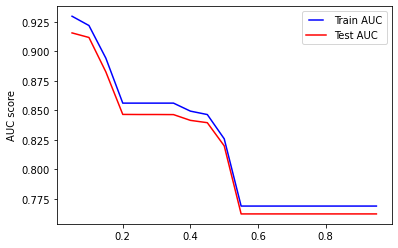

    N     Train      Test
 0.05  0.929610  0.915491
 0.10  0.921756  0.911628
 0.15  0.894089  0.882461
 0.20  0.856036  0.846471
 0.25  0.856036  0.846392
 0.30  0.856036  0.846390
 0.35  0.856036  0.846311
 0.40  0.849254  0.841437
 0.45  0.846362  0.839461
 0.50  0.825799  0.819838
 0.55  0.768862  0.762210
 0.60  0.768862  0.762210
 0.65  0.768862  0.762210
 0.70  0.768862  0.762210
 0.75  0.768862  0.762210
 0.80  0.768862  0.762210
 0.85  0.768862  0.762210
 0.90  0.768862  0.762210
 0.95  0.768862  0.762210


In [ ]:

data = []
treeClassifier = DecisionTreeClassifier

for n in min_samples_split:
    rtc = treeClassifier(max_depth=40, min_samples_split=n)

    rtc.fit(train_features, train_target)

    xfpr, xtpr, _ = roc_curve(train_target, rtc.predict(train_features))

    yfpr, ytpr, _ = roc_curve(test_target, rtc.predict(test_features))
    x, y = auc(xfpr, xtpr), auc(yfpr, ytpr)
    print(n, x, y)

    data.append([n, x, y])

# %% 
data = pd.DataFrame(data, columns=['N', 'Train', 'Test'])

line1, = plt.plot(data['N'], data['Train'], 'b', label='Train AUC')
line2, = plt.plot(data['N'], data['Test'], 'r', label='Test AUC')
# line3, = plt.plot(data['N'], data['CV'], 'y', label='CV AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')

# plt.xlabel('min samples leaf')
plt.show()
print(data.to_string(index=False))

